# Dependencies
Install required packages (skip if already installed).

In [1]:
%pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


# Environment setup
Load .env overrides, configure dataset/devices, and load or train the PPO policy + ThresholdRefinementEnv.

In [1]:
import osfrom pathlib import Pathfrom dotenv import load_dotenvfrom stable_baselines3 import PPOfrom envionments.threshold_refinement import ThresholdRefinementEnvfrom utility.dataset import load_pascal_voc2007, load_custom_datasetfrom utility.torch_utils import get_default_devicefrom utility.logging_utils import setup_loggingfrom utility.evaluation import evaluate_policy, summarize_stats, EvalHistoryCallback# Load .env but do not override pre-set values in this runtimeload_dotenv(".env", override=False)setup_logging()# Defaults for more credible runs and GPU usage (Metal on macOS)os.environ.setdefault("RL_DATA_LIMIT", "1000")os.environ.setdefault("RL_TOTAL_TIMESTEPS", "50000")os.environ.setdefault("RL_EVAL_EPISODES", "10")os.environ.setdefault("RL_LEARNING_RATE", "3e-4")os.environ.setdefault("RL_DEVICE", "cpu")os.environ.setdefault("DETECTOR_DEVICE", "mps")# Model-agnostic post-processing knobsos.environ.setdefault("RL_NMS_IOU", "0.7")os.environ.setdefault("RL_MAX_DET", "200")os.environ.setdefault("RL_MAX_NMS_DELTA", "0.1")os.environ.setdefault("RL_MAX_DET_DELTA", "50")VOC_ROOT = os.getenv("VOC_ROOT", "data/voc")IMAGE_DIR = os.getenv("IMAGE_DIR")LABEL_DIR = os.getenv("LABEL_DIR")DATA_LIMIT = int(os.getenv("RL_DATA_LIMIT", "1000"))TOTAL_TIMESTEPS = int(os.getenv("RL_TOTAL_TIMESTEPS", "50000"))LEARNING_RATE = float(os.getenv("RL_LEARNING_RATE", "3e-4"))MODEL_PATH = os.getenv("RL_MODEL_PATH", "rl_threshold_tuner.zip")# Stronger env knobs for learning signalENV_KWARGS = {    "max_delta": float(os.getenv("RL_MAX_DELTA", "0.15")),    "max_steps": int(os.getenv("RL_MAX_STEPS", "20")),    "initial_threshold_range": (0.3, 0.7),    "box_count_penalty": float(os.getenv("RL_BOX_COUNT_PENALTY", "0.05")),    "initial_nms_iou": float(os.getenv("RL_NMS_IOU", "0.7")),    "max_det": int(os.getenv("RL_MAX_DET", "200")),    "max_nms_delta": float(os.getenv("RL_MAX_NMS_DELTA", "0.1")),    "max_det_delta": int(os.getenv("RL_MAX_DET_DELTA", "50")),}POLICY_DEVICE = get_default_device(env_var="RL_DEVICE")DETECTOR_DEVICE = get_default_device(env_var="DETECTOR_DEVICE")if IMAGE_DIR:    dataset = load_custom_dataset(        IMAGE_DIR,        LABEL_DIR or IMAGE_DIR,        annotation_format="yolo_txt",        limit=DATA_LIMIT,    )else:    dataset = load_pascal_voc2007(        VOC_ROOT, image_set="trainval", limit=DATA_LIMIT, download=True    )env = ThresholdRefinementEnv(dataset, device=POLICY_DEVICE, detector_device=DETECTOR_DEVICE, **ENV_KWARGS)def make_eval_callback(model):    return EvalHistoryCallback(        eval_fn=lambda: summarize_stats(            evaluate_policy(                model,                dataset,                episodes=3,                deterministic=True,                device=POLICY_DEVICE,                detector_device=DETECTOR_DEVICE,                env_kwargs=ENV_KWARGS,            )        ),        eval_freq=5000,        name="eval",    )cb = Noneif Path(MODEL_PATH).exists():    try:        model = PPO.load(MODEL_PATH, device=POLICY_DEVICE)        model.set_env(env)        cb = make_eval_callback(model)        print(f"Loaded existing model from {MODEL_PATH}")    except ValueError as err:        print(f"Model at {MODEL_PATH} incompatible with current env ({err}); retraining.")        model = PPO("MlpPolicy", env, verbose=1, learning_rate=LEARNING_RATE, n_steps=512, device=POLICY_DEVICE)        cb = make_eval_callback(model)        model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=cb)        model.save(MODEL_PATH)        print(f"Trained and saved model to {MODEL_PATH}")else:    model = PPO("MlpPolicy", env, verbose=1, learning_rate=LEARNING_RATE, n_steps=512, device=POLICY_DEVICE)    cb = make_eval_callback(model)    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=cb)    model.save(MODEL_PATH)    print(f"Trained and saved model to {MODEL_PATH}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.22     |
|    ep_rew_mean     | 1.45     |
| time/              |          |
|    fps             | 18       |
|    iterations      | 1        |
|    time_elapsed    | 28       |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3           |
|    ep_rew_mean          | 0.826       |
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 2           |
|    time_elapsed         | 52          |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.016738024 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss   

KeyboardInterrupt: 

# Evaluate policy
Run evaluation rollouts on the dataset and print summary IoU stats.

2025-12-14 14:51:46,360 | INFO | utility.evaluation | Evaluation summary: episodes=10 mean_final_iou=0.4384 std_final_iou=0.3667 mean_return=8.9576 mean_steps=20.00


Episodes: 10
Mean final IoU: 0.4384 +/- 0.3667
Mean return: 8.9576
Mean steps: 20.00
Per-episode final IoUs: [0.1303, 0.3402, 0.8821, 0.1349, 0.0947, 0.0, 0.9633, 0.7098, 0.204, 0.9251]


<Axes: title={'center': 'Threshold trajectory per evaluation episode'}, xlabel='Step', ylabel='Confidence threshold'>

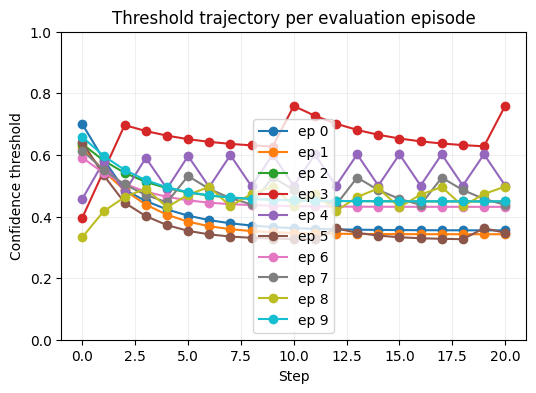

In [ ]:
import os

from dotenv import load_dotenv
from utility.evaluation import evaluate_policy, summarize_stats, plot_threshold_trajectories

load_dotenv(".env", override=False)
os.environ.setdefault("RL_EVAL_EPISODES", "10")
EVAL_EPISODES = int(os.getenv("RL_EVAL_EPISODES", "10"))

stats = evaluate_policy(
    model,
    dataset,
    episodes=EVAL_EPISODES,
    device=POLICY_DEVICE,
    detector_device=DETECTOR_DEVICE,
    env_kwargs=ENV_KWARGS,
)
summary = summarize_stats(stats)
print("Episodes:", summary["episodes"])
print(f"Mean final IoU: {summary['mean_final_iou']:.4f} +/- {summary['std_final_iou']:.4f}")
print(f"Mean return: {summary['mean_return']:.4f}")
print(f"Mean steps: {summary['mean_steps']:.2f}")
print("Per-episode final IoUs:", [round(s.final_iou, 4) for s in stats])

plot_threshold_trajectories(stats)


# Per-episode diagnostics
Plot threshold, IoU, and reward trajectories, plus the final IoU distribution.

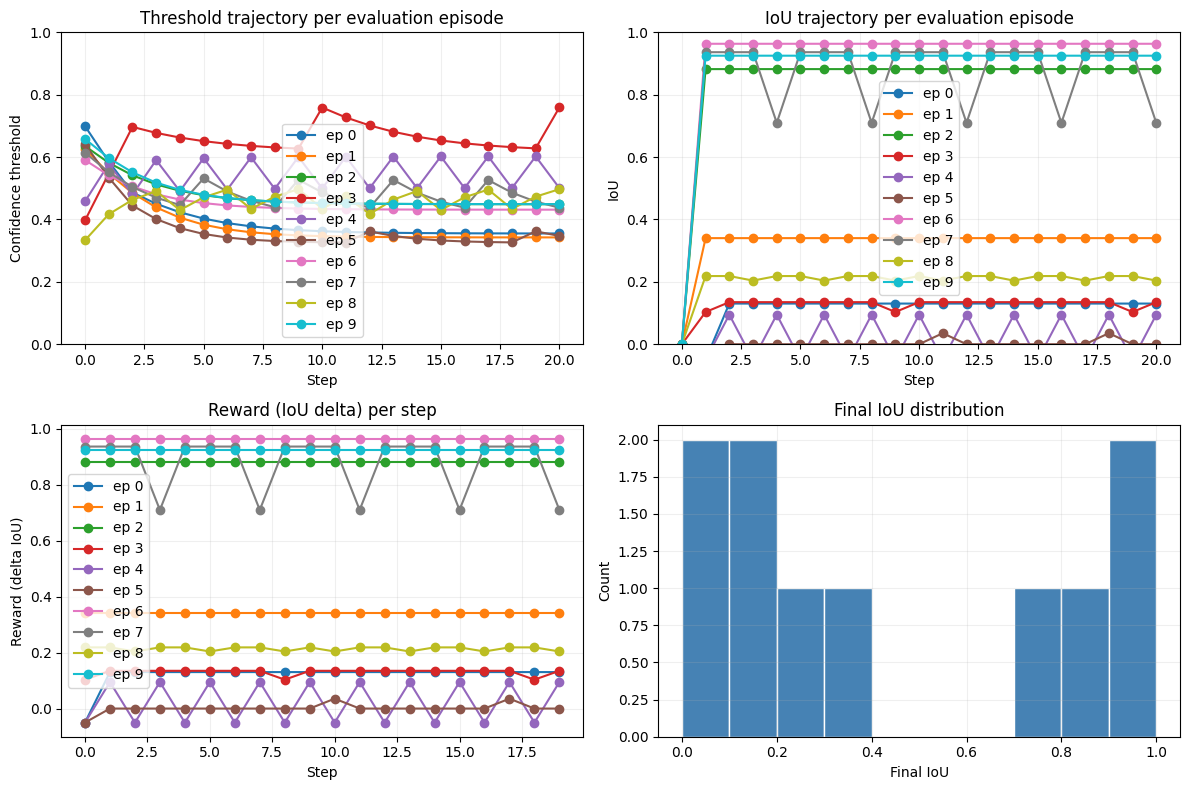

In [ ]:
import matplotlib.pyplot as plt
from utility.evaluation import (
    plot_threshold_trajectories,
    plot_iou_trajectories,
    plot_reward_trajectories,
    plot_final_iou_histogram,
)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_threshold_trajectories(stats, ax=axes[0, 0])
plot_iou_trajectories(stats, ax=axes[0, 1])
plot_reward_trajectories(stats, ax=axes[1, 0])
plot_final_iou_histogram(stats, ax=axes[1, 1])
plt.tight_layout()


# Detection-count accuracy vs baseline
Compare how well the policy vs a fixed-threshold YOLO match the ground-truth box count.

In [ ]:
from utility.evaluation import plot_detection_count_accuracy
fig, ax = plt.subplots(figsize=(7,4))
plot_detection_count_accuracy(
    stats,
    dataset,
    baseline_threshold=0.5,
    detector_device=DETECTOR_DEVICE,
    ax=ax,
)
plt.tight_layout()


NameError: name 'plt' is not defined

# Learning curve
Plot mean_final_iou and mean_return tracked during training.

<Axes: title={'center': 'Learning curve (evaluation)'}, xlabel='Timesteps', ylabel='Score'>

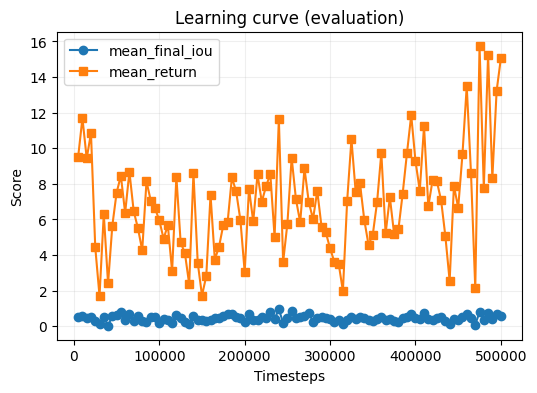

In [ ]:
from utility.evaluation import plot_learning_curve

# Plot learning curve from callback history
fig, ax = plt.subplots(figsize=(6,4))
plot_learning_curve(cb.history, ax=ax)


## Compare RL policy vs baseline YOLO

Run quantitative baselines at fixed thresholds and plot qualitative side-by-side detections.

### Quantitative baseline comparison
Evaluate the saved policy against multiple fixed-confidence baselines; adjust COMPAR* env vars to change the sweep.

In [ ]:
import os
import json
from dotenv import load_dotenv
from utility.model_comparison import compare_models

# Lightweight comparison controls (tune here instead of editing code)
load_dotenv('.env', override=False)
COMPARE_DATA_LIMIT = int(os.getenv('COMPARE_DATA_LIMIT', '100'))
COMPARE_EPISODES = int(os.getenv('COMPARE_EPISODES', '3'))
COMPARE_THRESHOLDS = [float(t) for t in os.getenv('COMPARE_THRESHOLDS', '0.3,0.5,0.7').split(',')]

comparison = compare_models(
    model_path=MODEL_PATH,
    episodes=COMPARE_EPISODES,
    dataset_limit=COMPARE_DATA_LIMIT,
    thresholds=COMPARE_THRESHOLDS,
)
print(json.dumps(comparison, indent=2))


2025-12-14 14:51:46,669 | INFO | utility.model_comparison | Using VOC2007 root=./data/voc limit=100
2025-12-14 14:51:46,669 | INFO | utility.model_comparison | Running comparison on dataset=voc2007(./data/voc) episodes=3 thresholds=[0.3, 0.5, 0.7]
2025-12-14 14:51:48,474 | INFO | utility.evaluation | Evaluation summary: episodes=3 mean_final_iou=0.5933 std_final_iou=0.2837 mean_return=9.0926 mean_steps=15.00
2025-12-14 14:51:48,548 | INFO | utility.model_comparison | Evaluating baseline at threshold=0.30



0: 480x640 3 chairs, 1 dining table, 17.7ms
Speed: 1.0ms preprocess, 17.7ms inference, 17.8ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 car, 21.8ms
Speed: 1.2ms preprocess, 21.8ms inference, 3.8ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 1 horse, 24.6ms
Speed: 1.4ms preprocess, 24.6ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 bus, 25.8ms
Speed: 1.3ms preprocess, 25.8ms inference, 3.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 bicycle, 1 traffic light, 113.4ms
Speed: 2.4ms preprocess, 113.4ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 1 car, 1 horse, 140.7ms
Speed: 2.3ms preprocess, 140.7ms inference, 26.6ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 2 dogs, 26.6ms
Speed: 1.5ms preprocess, 26.6ms inference, 4.2ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 car, 2 motorcycles, 27.1ms
Speed: 1.5ms preprocess, 27.1

### Qualitative policy vs baseline visualization
Show policy detections at the learned threshold alongside a fixed-threshold baseline.

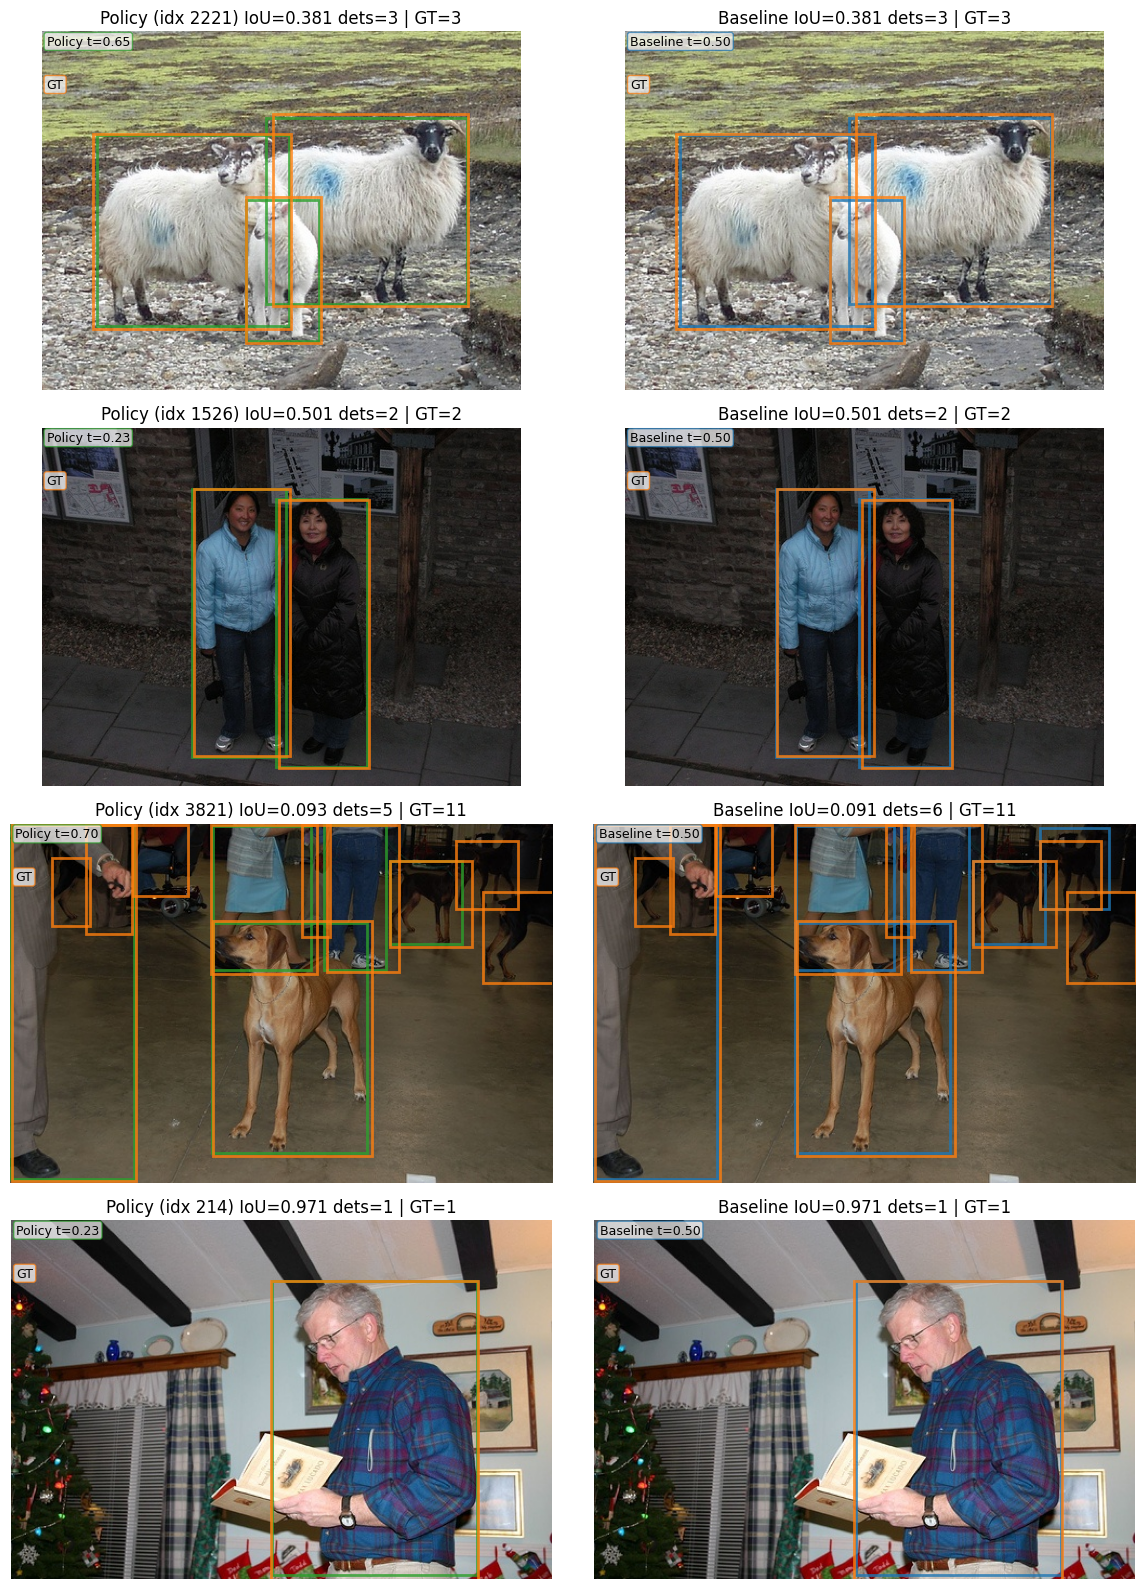

In [ ]:
from utility.evaluation import visualize_policy_vs_baseline

fig = visualize_policy_vs_baseline(
    model,
    dataset,
    baseline_threshold=0.5,
    deterministic=True,
    device=POLICY_DEVICE,
    detector_device=DETECTOR_DEVICE,
)
